## Example Alpha Factors with Cointegrated Pairs
In this notebook, we generate two example alpha factors with the information provided by the cointegrated pairs. A pair of stocks is called cointegrated if their prices move together over time and the distance between the prices is stable. There are Quantopian lectures on the mathematical meaning of [cointegration](https://www.quantopian.com/lectures/integration-cointegration-and-stationarity) and [pairs trading strategy](https://www.quantopian.com/lectures/introduction-to-pairs-trading). If you are interested please check them out but they are not a prerequisite for this notebook. The above lectures introduce the general idea of exploiting price divergences between pairs. This method has been around for a long time and we, in fact, have our own implementation of it.

In this notebook, we want to introduce a different idea to use pairs. The basic idea is that if some event happens to one leg of the pair, like an earnings announcement that beats estimates, it is more likely that the market would price a higher chance of the same thing will happen to the other leg too, so in this case, the other leg would also beat estimates. This notebook develops this idea with two simple examples. These serve to give you an idea, but we ask you to use your creativity to come up with novel ideas and submit them to us.

In addition to a different take on pairs trading, this notebook also shows how a factor can be constructed from the pair information. Usually there is logic to directly going long/short stocks if prices diverge. Here instead we want to provide individual scores.

In [2]:
import pandas as pd
import numpy as np

from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.research import run_pipeline
from quantopian.pipeline.factors import BusinessDaysSincePreviousEvent

In [3]:
# It would be helpful to split the dataset as a training dataset and test dataset when designing algorithm.
# The dataset here we use in this notebook is the training dataset.
training_start_date = '2012-01-04'
training_end_date = '2018-06-11'

from zipline.utils.calendars import get_calendar
calendar = get_calendar('NYSE')
trading_calendar = calendar.all_sessions
trading_calendar_index = trading_calendar[(trading_calendar >= training_start_date) \
                                          & (trading_calendar <= training_end_date)]

#### Step 1: Upload the Daily Lists of Pairs to Q Platform

The data that we provide for you here is a major part of pairs we identified beforehand. There will be more information on how that was done but those details are not important in this exercise. We will just accept the pairs as given. The pair information is encoded in a .csv file that can be uploaded as self-serve data to build the Pipeline. First however, let's have a brief look at the data. 

![pairs_self_serve_dataset](https://image-proxy.quantopian.com/39c3de02b0cc91cdb922a1b20afa8e92ca5028d7/68747470733a2f2f73332e616d617a6f6e6177732e636f6d2f7175616e746f7069616e5f7374617469635f6173736574732f7075626c69632f70616972735f73656c665f73657276655f646174617365742e706e67)

The column `trade_date_minus_one` is the date when we discovered the pair, and the column `trade_date` is the point at which we can trade the pair. In order to encode the pair information in a way that self-serve accepts, we had to get a little creative. Basically, if two stocks contribute a pair, they will have the same number in one of the groups. You can see that `ABM` and `ADSK` are a pair because they both have a `1` in the column `group_1`. A stock can be in more than one pair. For this reason, we encoded the information in multiple columns `group_i`. For example, you can see in column `group_2` that `ABM` is not just a pair with `ADSK`, but also with `APH`. The number `0` is a place-holder meaning no pair. The group number does not mean to reflect the relative strength of cointegration. The pairs in different groups are equally important.

Now, we are ready upload the `pairs_self_serve_dataset.csv` as a self-serve dataset on [Q web](https://www.quantopian.com/account#data). To quickly learn how to upload it, please refer [Upload Your Custom Datasets and Signals with Self-Serve Data](https://www.quantopian.com/posts/upload-your-custom-datasets-and-signals-with-self-serve-data).

Note: When uploading `pairs_self_serve_dataset.csv` as a self-serve dataset, please set `trade_date_minus_one` as `Primary Date` and `ticker` as `Primary Asset`. The column types of `trade_date_minus_one`, `trade_date`, `ticker`, and `group_i` are `date`, `datetime`, `string`, and `number`. 

Let's run the corresponding Pipeline that gets the dataset we uploaded. First, we need to run the import statement:

In [4]:
# from quantopian.pipeline.data.user_[user_ID] import [dataset name] 
from quantopian.pipeline.data.user_57e2b12557e9c947ce001019 import pairs_self_serve_dataset

In [5]:
# Columns in pairs_self_serve_dataset:
pairs_self_serve_dataset.columns

frozenset({pairs_self_serve_dataset<US>.group_3::float64,
           pairs_self_serve_dataset<US>.group_9::float64,
           pairs_self_serve_dataset<US>.group_1::float64,
           pairs_self_serve_dataset<US>.group_17::float64,
           pairs_self_serve_dataset<US>.group_16::float64,
           pairs_self_serve_dataset<US>.group_15::float64,
           pairs_self_serve_dataset<US>.group_14::float64,
           pairs_self_serve_dataset<US>.group_13::float64,
           pairs_self_serve_dataset<US>.group_12::float64,
           pairs_self_serve_dataset<US>.group_11::float64,
           pairs_self_serve_dataset<US>.trade_date::datetime64[ns],
           pairs_self_serve_dataset<US>.group_8::float64,
           pairs_self_serve_dataset<US>.asof_date::datetime64[ns],
           pairs_self_serve_dataset<US>.group_7::float64,
           pairs_self_serve_dataset<US>.group_6::float64,
           pairs_self_serve_dataset<US>.group_5::float64,
           pairs_self_serve_dataset<US>.group_

There are 17 groups of pairs. First, let's take a look at the data in the first 3 groups.

In [6]:
# Check the number of days since the the data was updated. Here, we consider the pairs_self_serve_dataset
# to be fresh if it's less than 1 days old. 
is_pairs_data_fresh = (BusinessDaysSincePreviousEvent(inputs=[pairs_self_serve_dataset.asof_date]) <= 1)

In [7]:
pipe = Pipeline(
    columns={
        'group_1': pairs_self_serve_dataset.group_1.latest,
        'group_2': pairs_self_serve_dataset.group_2.latest,
        'group_3': pairs_self_serve_dataset.group_3.latest,
        'trade_date': pairs_self_serve_dataset.trade_date.latest,
        'asof_date': pairs_self_serve_dataset.asof_date.latest
    },
    screen=pairs_self_serve_dataset.trade_date.latest.notnull()&is_pairs_data_fresh
)
df = run_pipeline(pipe, training_start_date, training_end_date)
df.head()

asof_date  group_1  group_2  \
2012-01-05 00:00:00+00:00 Equity(52 [ABM])  2012-01-04      1.0      2.0   
                          Equity(67 [ADSK]) 2012-01-04      1.0     15.0   
                          Equity(88 [ACI])  2012-01-04     28.0     29.0   
                          Equity(99 [ACO])  2012-01-04     33.0     34.0   
                          Equity(122 [ADI]) 2012-01-04     47.0     48.0   

                                             group_3 trade_date  
2012-01-05 00:00:00+00:00 Equity(52 [ABM])       3.0 2012-01-05  
                          Equity(67 [ADSK])     16.0 2012-01-05  
                          Equity(88 [ACI])      30.0 2012-01-05  
                          Equity(99 [ACO])      35.0 2012-01-05  
                          Equity(122 [ADI])     49.0 2012-01-05

As we can see, the date we run the pipeline for is the `trade_date` and the `asof_date` is the `trade_date_minus_one`. 

We could transform this into the daily lists of pairs. For example, when `trade_date` is `2012-01-05`, we could obtain a list of pairs from `group_1` as follows:

In [8]:
date = '2012-01-05'
df_temp = df.xs(date, level=0)
group_1 = df_temp.loc[:, 'group_1']
pairs = group_1[group_1!=0] # exclude the assets with values equal to 0
pairs.head()

Equity(52 [ABM])      1.0
Equity(67 [ADSK])     1.0
Equity(88 [ACI])     28.0
Equity(99 [ACO])     33.0
Equity(122 [ADI])    47.0
Name: group_1, dtype: float64

In [9]:
list_pairs = []
for _, pair in pairs.groupby(pairs): # select the assets share same value
    list_pairs = list_pairs + [(pair.index[0].symbol, pair.index[1].symbol)]

In [10]:
# First 5 elements of the cointegrated pairs:
list_pairs[:5]

[(u'ABM', u'ADSK'),
 (u'ACI', u'LM'),
 (u'ACO', u'AIN'),
 (u'ADI', u'APD'),
 (u'AEP', u'DUK')]

## Step 2: Build Alpha Factors

#### Example 1: The `earnings_surprise` Computed with Factset Data

To get the data of each asset's earning surprise, we use the code borrowed from [New Data: Factset Estimates](https://www.quantopian.com/posts/new-data-factset-estimates).

In [11]:
import quantopian.pipeline.data.factset.estimates as fe  

# Slice the PeriodicConensus and Actuals DataSetFamilies into DataSets. In this context,  
# fq0_eps_cons is a DataSet containing consensus estimates data about EPS for the  
# most recently reported fiscal quarter. fq0_eps_act is a DataSet containing the actual  
# reported EPS for the most recently reported quarter.
fq0_eps_cons = fe.PeriodicConsensus.slice('EPS', 'qf', 0)  
fq0_eps_act = fe.Actuals.slice('EPS', 'qf', 0)

# Get the latest mean consensus EPS estimate for the last reported quarter.  
fq0_eps_cons_mean = fq0_eps_cons.mean.latest

# Get the EPS value from the last reported quarter.  
fq0_eps_act_value = fq0_eps_act.actual_value.latest

# Define a surprise factor to be the relative difference between the estimated and  
# reported EPS.  
fq0_surprise = (fq0_eps_act_value - fq0_eps_cons_mean) / fq0_eps_cons_mean

The idea of the alpha factor is that if one stock of a cointegrated pair has a positive earnings surprise, then the other stock from the same pair may have a positive move in price. Let us define the corresponding custom factor.

In [12]:
# Here, we consider the EarningsSurprises data to be fresh if it's less than 30 days old, 
# but it could be changed to a longer time period or shorter time period.

is_es_data_fresh = (BusinessDaysSincePreviousEvent(inputs=[fq0_eps_act.asof_date]) <= 30)
class Pairs_ES(CustomFactor):
    window_length = 1
    # inputs: One group of pairs and the data of earnings_surprises
    # mask = is_es_data_fresh
    def compute(self, today, asset_ids, out, one_group_pairs, earnings_surprises):
        # store the input data, one_group_pairs, into a pandas Series with sid numbers
        # as index
        pairs = pd.Series(one_group_pairs[0, :], index=asset_ids) 
        # exclude the assets with values equal to 0
        pairs = pairs[pairs != 0] 
        # store the input data, earnings_surprises, into a pandas Series with sid numbers
        # as index
        earnings_surprises = pd.Series(earnings_surprises[0, :], index=asset_ids)
        
        output = pd.Series(index=asset_ids)
        # find the assets that share the same value, and save their sids as leg_1 and leg_2
        for _, pair in pairs.groupby(pairs): 
            # check if some assets in the pairs are excluded from pipeline
            if len(pair.index) == 2:             
                (leg_1, leg_2) = pair.index
                # assign the earnings_surprises score of pair leg 2 to pair leg 1
                output[leg_1] = earnings_surprises[leg_2]
                # assign the earnings_surprises score of pair leg 1 to pair leg 2
                output[leg_2] = earnings_surprises[leg_1]
        out[:] = output.values

Then, we could define a pipeline to run this custom factor for the first group of pairs, and include the values of group 1 and the data of earning surprises as reference.

In [13]:
def make_pipeline_es_sample():  
    pipe = Pipeline()    
    pipe.add(fq0_surprise, 'es_data') # earning surprises
    pipe.add(pairs_self_serve_dataset.group_1.latest, 'group_1') # the group 1 of pairs_self_serve_dataset 
    earnings_surprises_group_1 = Pairs_ES(
                inputs=[pairs_self_serve_dataset.group_1.latest, 
                        fq0_surprise],
                mask=is_pairs_data_fresh
            )
    pipe.add(earnings_surprises_group_1, 'group_1' + '_es')
    
    pipe.set_screen(pairs_self_serve_dataset.trade_date.latest.notnull()\
                    & is_es_data_fresh & earnings_surprises_group_1.notnull())
    return pipe

pipe_es_sample_output = run_pipeline(make_pipeline_es_sample(), training_start_date, training_end_date)

In [14]:
pipe_es_sample_output.head()

es_data  group_1  group_1_es
2012-01-05 00:00:00+00:00 Equity(52 [ABM])     0.020690      1.0    0.081610
                          Equity(484 [ATU])    0.170686    169.0    0.016500
                          Equity(739 [BBBY])   0.073203    315.0    0.002109
                          Equity(1010 [BNS])   0.024690    366.0    0.250860
                          Equity(1941 [CTAS])  0.145296    541.0   -0.003879

Since there are multiple groups in `pairs_self_serve_dataset` and some stocks may be in multiple groups (i.e. some stocks are shared by different cointegrated pairs. e.g. (`A`, `B`) and (`A`, `C`)), we would like to combine the results computed by the custom function, `Pairs_ES` for multiple groups. We define another custom function named `MeanFactor` to combine them by taking their average values as the alpha factor.

In [17]:
# Compute the mean factor.
class MeanFactor(CustomFactor):
    window_length=1
    def compute(self, today, asset_ids, out, *inputs):
        output = pd.DataFrame(index=asset_ids)
        for i in range(0, len(inputs)):
            output['col_' + str(i)] = inputs[i][0,:]
        out[:] = output.mean(axis=1).values 

def make_pipeline_es():  
    pipe = Pipeline()  
    earnings_surprises = np.asarray([]) # store the results computed by Pairs_ES for each group
    for col in pairs_self_serve_dataset.columns: 
        if 'group' in col.name:  # for loop each group
            earnings_surprises_per_group = Pairs_ES(
                inputs=[col.latest, fq0_surprise],
                mask=is_pairs_data_fresh
            )
            earnings_surprises = np.append(earnings_surprises, 
                                           earnings_surprises_per_group) 
    
    alpha_factor =  MeanFactor(inputs=earnings_surprises).winsorize(0.2, 0.98)  # compute the mean factor
    pipe.add(alpha_factor, 'es')
    screen_zeros = (alpha_factor != 0.0)
    screen = (screen_zeros & pairs_self_serve_dataset.trade_date.latest.notnull()\
              & is_es_data_fresh & alpha_factor.notnull())
    pipe.set_screen(screen)
    return pipe

pipe_es_output = run_pipeline(make_pipeline_es(), training_start_date, training_end_date)

Before running this alpha factor in the algorithm environment, we can use `alphalens` to analyze it and maybe tweak it. 

In [18]:
trading_day_delta = calendar.day
px = get_pricing(
        pipe_es_output.index.get_level_values(1).unique(), pd.Timestamp(training_start_date),
        pd.Timestamp(training_end_date) + 252*trading_day_delta,
        fields=['open_price']).iloc[0, :, :]

In [19]:
from alphalens.utils import get_clean_factor_and_forward_returns
factor_data = get_clean_factor_and_forward_returns(
    factor=pipe_es_output['es'], 
    prices=px,
    bins=(-1000,0,1000),
    quantiles=None,
    periods=range(1,35,5)
)

# Show the first 5 rows of merged_data.
factor_data.head(5) 

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D        6D       11D  \
date                      asset                                               
2012-01-05 00:00:00+00:00 Equity(52 [ABM])    -0.016569  0.008798  0.036108   
                          Equity(484 [ATU])    0.019900  0.034640  0.056289   
                          Equity(739 [BBBY])   0.013004  0.005584  0.042905   
                          Equity(1010 [BNS])  -0.007455 -0.001969  0.054617   
                          Equity(1941 [CTAS])  0.012203  0.033824  0.049903   

                                                    16D       21D       26D  \
date                      asset                                               
2012-01-05 00:00:00+00:00 Equity(52 [ABM])     0.056562  0.123407  0.094098   
                          Equity(484 [ATU])    0.086555  0.172673  0.202545   
                          Equity(739 [BBBY])   0.049671  0.062675  0.006766   
                          Equity(1010 [BNS])   0.019451  0.013946  0.034000   
                          Equity(1941 [CTAS])  0.025799  0.047420  0.053779   

                                                    31D    factor  \
date                      asset                                     
2012-01-05 00:00:00+00:00 Equity(52 [ABM])     0.104382  0.117128   
                          Equity(484 [ATU])    0.229356  0.043677   
                          Equity(739 [BBBY])   0.008275  0.001882   
                          Equity(1010 [BNS])   0.059138 -0.006574   
                          Equity(1941 [CTAS])  0.081244  0.045626   

                                               factor_quantile  
date                      asset                                 
2012-01-05 00:00:00+00:00 Equity(52 [ABM])                   2  
                          Equity(484 [ATU])                  2  
                          Equity(739 [BBBY])                 2  
                          Equity(1010 [BNS])                 1  
                          Equity(1941 [CTAS])                2

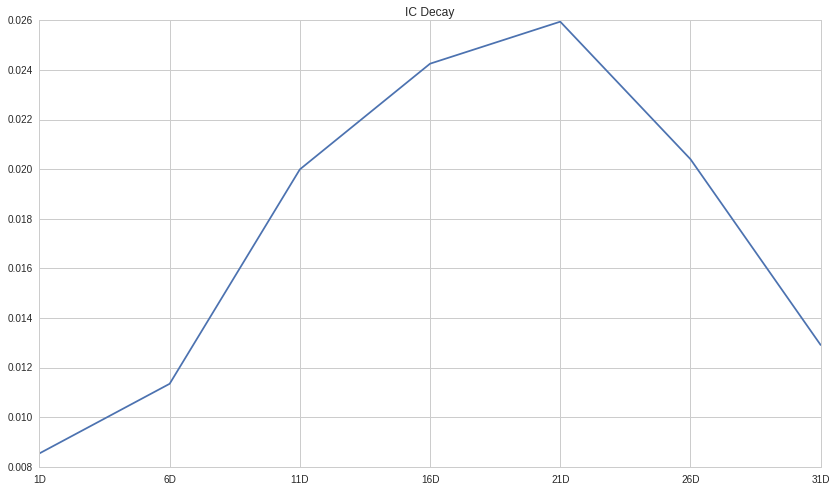

In [20]:
from alphalens.performance import mean_information_coefficient
mean_information_coefficient(factor_data).plot(title="IC Decay");

Quantiles Statistics


min        max      mean       std   count    count %
factor_quantile                                                            
1               -0.117952  -0.000002 -0.038924  0.025742   86910  30.986608
2                0.000006  45.305972  0.317150  1.367897  193566  69.013392

Returns Analysis


1D     6D    11D    16D  \
Ann. alpha                                       NaN    NaN    NaN    NaN   
beta                                             NaN    NaN    NaN    NaN   
Mean Period Wise Return Top Quantile (bps)     0.397  0.774  0.746  0.704   
Mean Period Wise Return Bottom Quantile (bps) -1.113 -2.212 -2.005 -1.839   
Mean Period Wise Spread (bps)                  1.537  3.098  2.858  2.654   

                                                 21D    26D    31D  
Ann. alpha                                       NaN    NaN    NaN  
beta                                             NaN    NaN    NaN  
Mean Period Wise Return Top Quantile (bps)     0.707  0.689  0.623  
Mean Period Wise Return Bottom Quantile (bps) -1.702 -1.612 -1.478  
Mean Period Wise Spread (bps)                  2.524  2.422  2.216

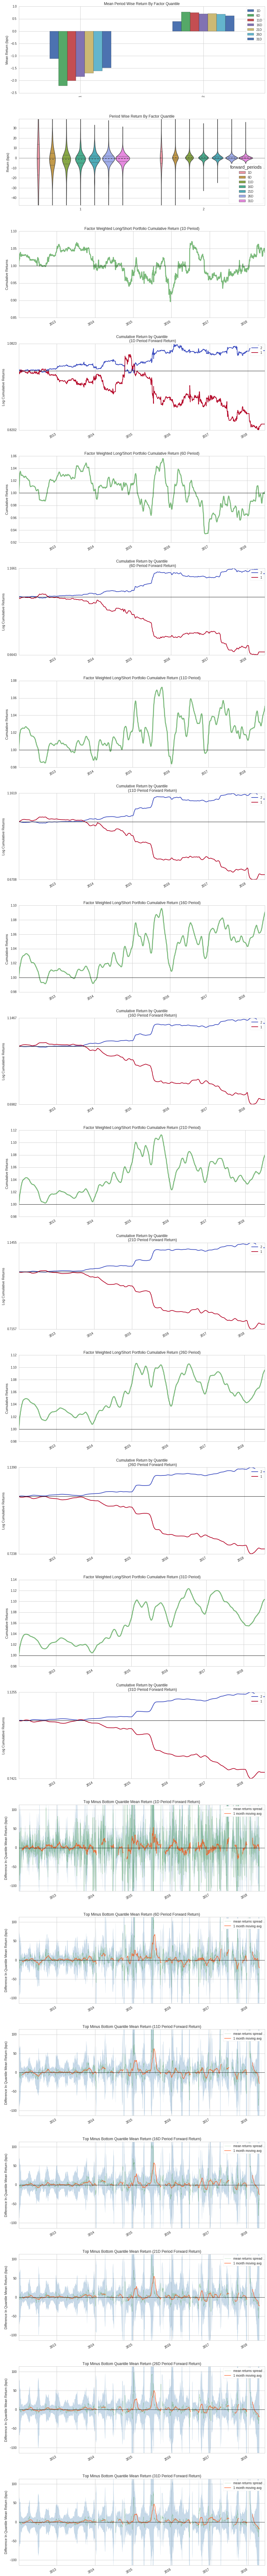

Information Analysis


1D     6D    11D    16D    21D    26D    31D
IC Mean           0.009  0.011  0.020  0.024  0.026  0.020  0.013
IC Std.           0.197  0.197  0.207  0.205  0.209  0.213  0.215
Risk-Adjusted IC  0.043  0.057  0.097  0.118  0.124  0.096  0.060
t-stat(IC)          NaN    NaN    NaN    NaN    NaN    NaN    NaN
p-value(IC)         NaN    NaN    NaN    NaN    NaN    NaN    NaN
IC Skew             NaN    NaN    NaN    NaN    NaN    NaN    NaN
IC Kurtosis         NaN    NaN    NaN    NaN    NaN    NaN    NaN

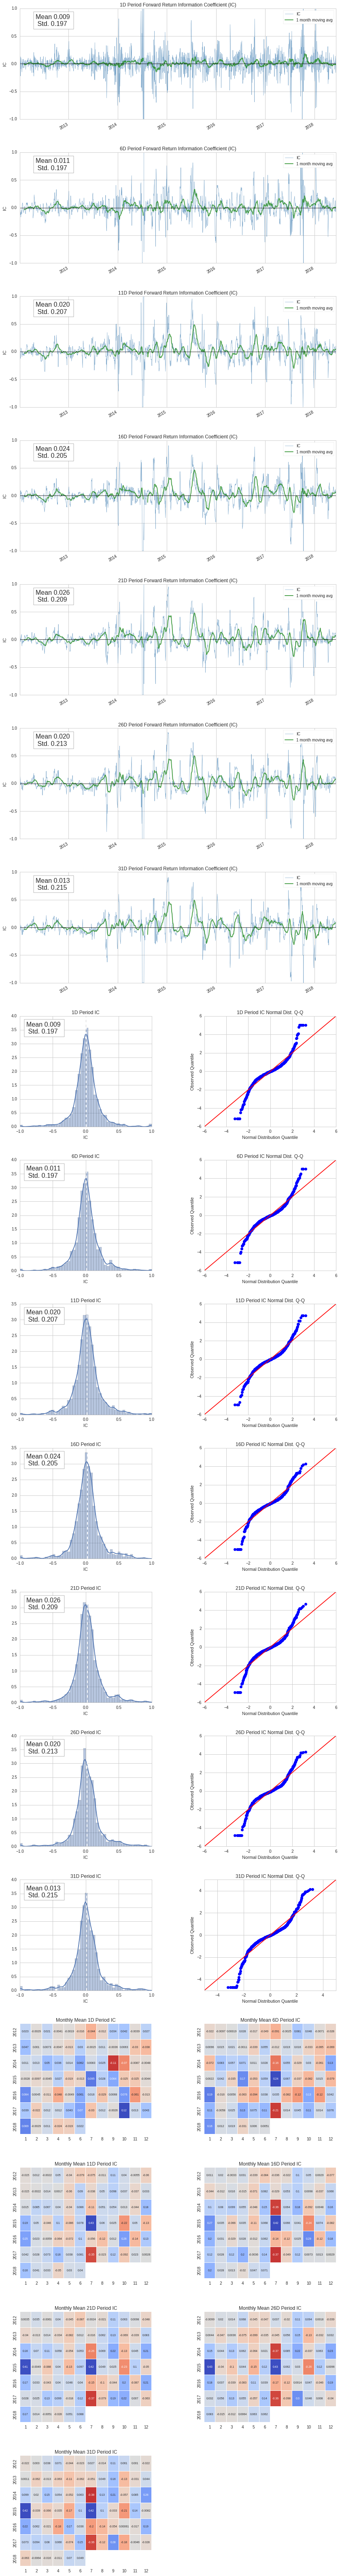

Turnover Analysis


11D    16D     1D    21D    26D    31D     6D
Quantile 1 Mean Turnover   0.546  0.695  0.086  0.807  0.898  0.973  0.364
Quantile 2 Mean Turnover   0.493  0.635  0.073  0.759  0.884  0.970  0.328

1D     6D    11D    16D    21D   26D  \
Mean Factor Rank Autocorrelation  0.962  0.794  0.658  0.533  0.436  0.32   

                                    31D  
Mean Factor Rank Autocorrelation  0.214

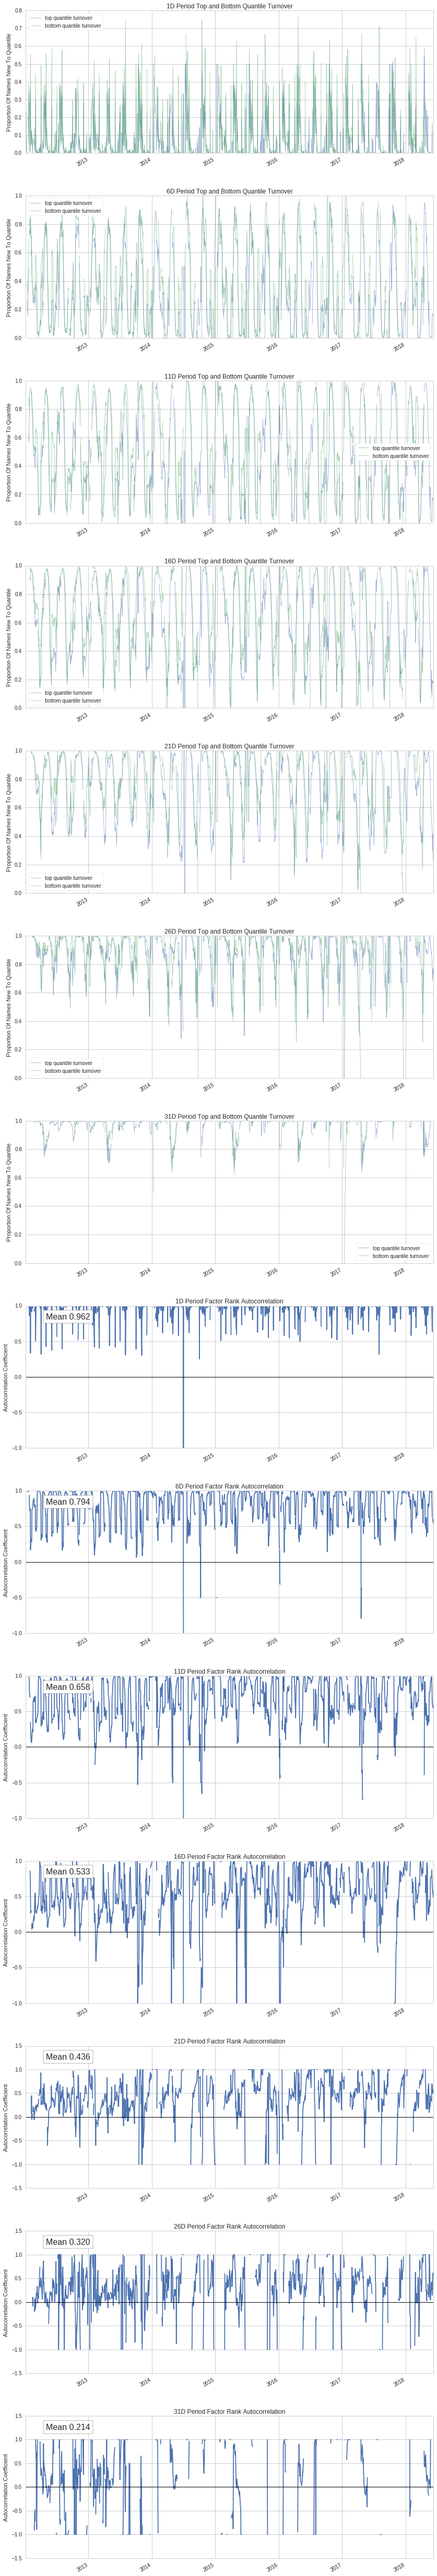

In [21]:
from alphalens.tears import create_full_tear_sheet

create_full_tear_sheet(factor_data=factor_data)
# Since the earnings data is quarterly based, the factor_data may not have values for every trading day. 
# That is why there are some NaN values and discrete lines in the tearsheet.

#### Example 2: Using `stocktwits`
This alpha factor is designed to be the average sentiment scores of the stocks in the same cointegrated pair. The idea is that one stock's alpha score here is not only influenced by its own sentiment score but also influenced by the other legs' sentiment score.

In [22]:
from quantopian.pipeline.data.psychsignal import stocktwits

Let us define a custom factor to compute the average sentiment scores of pair legs. Then, we can borrow the codes from the previous example to build the pipeline and run the alphalens tearsheet.

In [23]:
# The alpha scores of the assets in the same pair are designed to be their average sentiment scores.
class Pairs_Sentiment(CustomFactor):
    window_length = 1
    def compute(self, today, asset_ids, out, pair_groups, sentiment_score):
        pairs = pd.Series(pair_groups[0, :], index=asset_ids)
        pairs = pairs[pairs != 0]
        sentiment_score = pd.Series(sentiment_score[0, :], index=asset_ids)
        output = pd.Series(index=asset_ids)
        for _, pair in pairs.groupby(pairs):
            if len(pair.index) == 2:    
                (leg_1, leg_2) = pair.index
                # take the average of sentiment scores
                output[leg_1] = (sentiment_score[leg_1] + sentiment_score[leg_2]) / 2
                output[leg_2] = (sentiment_score[leg_1] + sentiment_score[leg_2]) / 2
        out[:] = output.values

In [24]:
def make_pipeline_sentiment():  
    pipe = Pipeline()  
    sentiment_scores = np.asarray([])
    for col in pairs_self_serve_dataset.columns:
        if 'group' in col.name:  
            sentiment_scores_per_group = Pairs_Sentiment(
                inputs=[col.latest, stocktwits.bull_minus_bear.latest],
                mask=is_pairs_data_fresh
            )
            sentiment_scores = np.append(sentiment_scores, sentiment_scores_per_group) 
    
    alpha_factor =  MeanFactor(inputs=sentiment_scores)
    pipe.add(alpha_factor, 'sentiment_score')
    screen_zeros = (alpha_factor != 0.0)
    screen = (pairs_self_serve_dataset.trade_date.latest.notnull()\
              &alpha_factor.notnull()\
              &screen_zeros)
              
    pipe.set_screen(screen)
    return pipe
pipe_sentiment_output = run_pipeline(make_pipeline_sentiment(), training_start_date, training_end_date)

In [25]:
trading_day_delta = calendar.day
px = get_pricing(
        pipe_sentiment_output.index.get_level_values(1).unique(), pd.Timestamp(training_start_date),
        pd.Timestamp(training_end_date) + 252*trading_day_delta,
        fields=['open_price']).iloc[0,:,:]

In [26]:
from alphalens.utils import get_clean_factor_and_forward_returns
factor_data = get_clean_factor_and_forward_returns(
    factor=pipe_sentiment_output['sentiment_score'], 
    prices=px,
    bins=(-100,0,100),
    quantiles=None,
    periods=range(20,180,30)
)

# Show the first 5 rows of merged_data.
factor_data.head(5) 

Dropped 0.6% entries from factor data: 0.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


20D       50D       80D  \
date                      asset                                             
2012-01-05 00:00:00+00:00 Equity(52 [ABM])   0.115580  0.147289  0.143861   
                          Equity(67 [ADSK])  0.241528  0.345847  0.311628   
                          Equity(88 [ACI])   0.046741 -0.198904 -0.360849   
                          Equity(99 [ACO])   0.079839  0.043123  0.196509   
                          Equity(122 [ADI])  0.113336  0.114834  0.104414   

                                                 110D      140D      170D  \
date                      asset                                             
2012-01-05 00:00:00+00:00 Equity(52 [ABM])   0.000114 -0.066503 -0.039308   
                          Equity(67 [ADSK])  0.064751  0.090365  0.087708   
                          Equity(88 [ACI])  -0.614805 -0.641462 -0.581457   
                          Equity(99 [ACO])   0.070056  0.049108  0.165548   
                          Equity(122 [ADI])  0.056872  0.092392  0.152057   

                                               factor  factor_quantile  
date                      asset                                         
2012-01-05 00:00:00+00:00 Equity(52 [ABM])   0.115357                2  
                          Equity(67 [ADSK])  0.094643                2  
                          Equity(88 [ACI])   1.419000                2  
                          Equity(99 [ACO])  -0.091429                1  
                          Equity(122 [ADI])  0.108571                2

Quantiles Statistics


min           max      mean       std   count  \
factor_quantile                                                           
1               -3.610000e+00 -4.270089e-18 -0.616684  0.513820  152766   
2                9.912706e-19  3.300000e+00  0.780161  0.567949  374453   

                   count %  
factor_quantile             
1                28.975815  
2                71.024185

Returns Analysis


20D    50D    80D   110D  \
Ann. alpha                                    -0.007 -0.003 -0.001  0.000   
beta                                          -0.025 -0.022 -0.020 -0.033   
Mean Period Wise Return Top Quantile (bps)    -2.433 -0.445  0.048  0.153   
Mean Period Wise Return Bottom Quantile (bps)  3.043 -1.186 -1.899 -2.538   
Mean Period Wise Spread (bps)                 -5.476  1.141  2.429  3.218   

                                                140D   170D  
Ann. alpha                                    -0.000 -0.001  
beta                                          -0.025 -0.013  
Mean Period Wise Return Top Quantile (bps)     0.460  0.815  
Mean Period Wise Return Bottom Quantile (bps) -3.685 -4.422  
Mean Period Wise Spread (bps)                  4.679  5.786

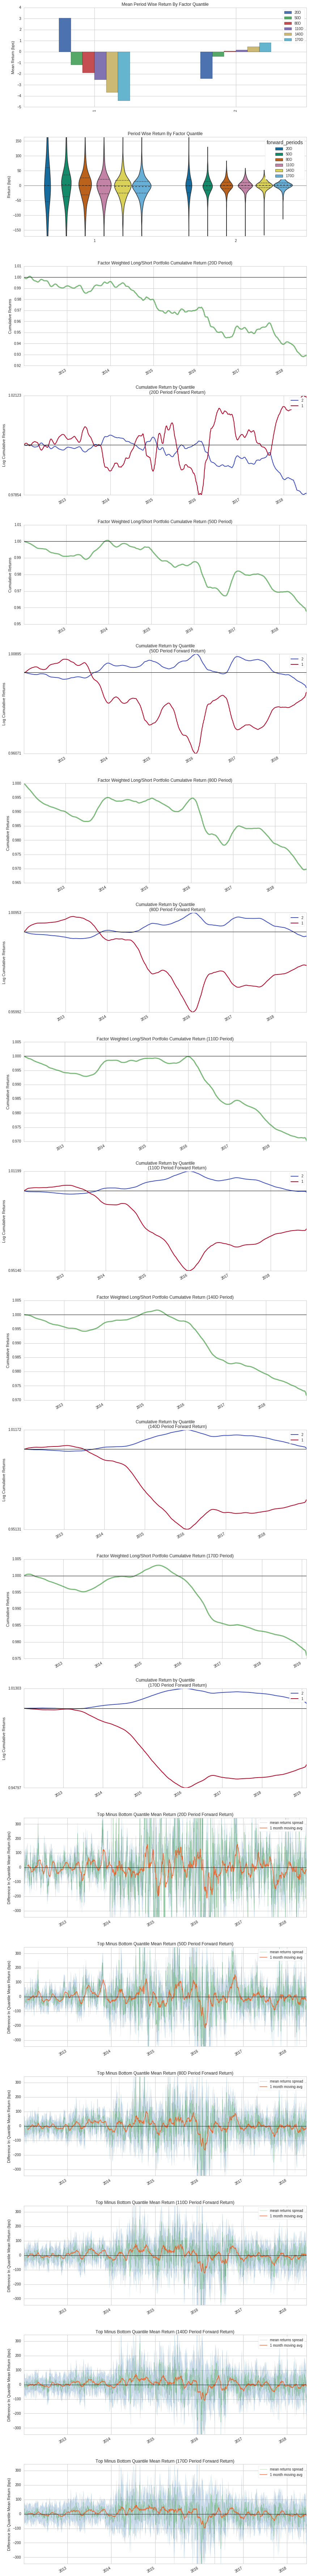

Information Analysis


20D    50D    80D   110D   140D   170D
IC Mean          -0.008 -0.008 -0.007 -0.011 -0.011 -0.009
IC Std.           0.101  0.098  0.095  0.093  0.091  0.089
Risk-Adjusted IC -0.080 -0.085 -0.072 -0.113 -0.116 -0.102
t-stat(IC)       -3.148 -3.352 -2.837 -4.473 -4.597 -4.008
p-value(IC)       0.002  0.001  0.005  0.000  0.000  0.000
IC Skew           0.015 -0.002 -0.035 -0.128 -0.087 -0.081
IC Kurtosis       0.258  0.250  0.164  0.212  0.258  0.337

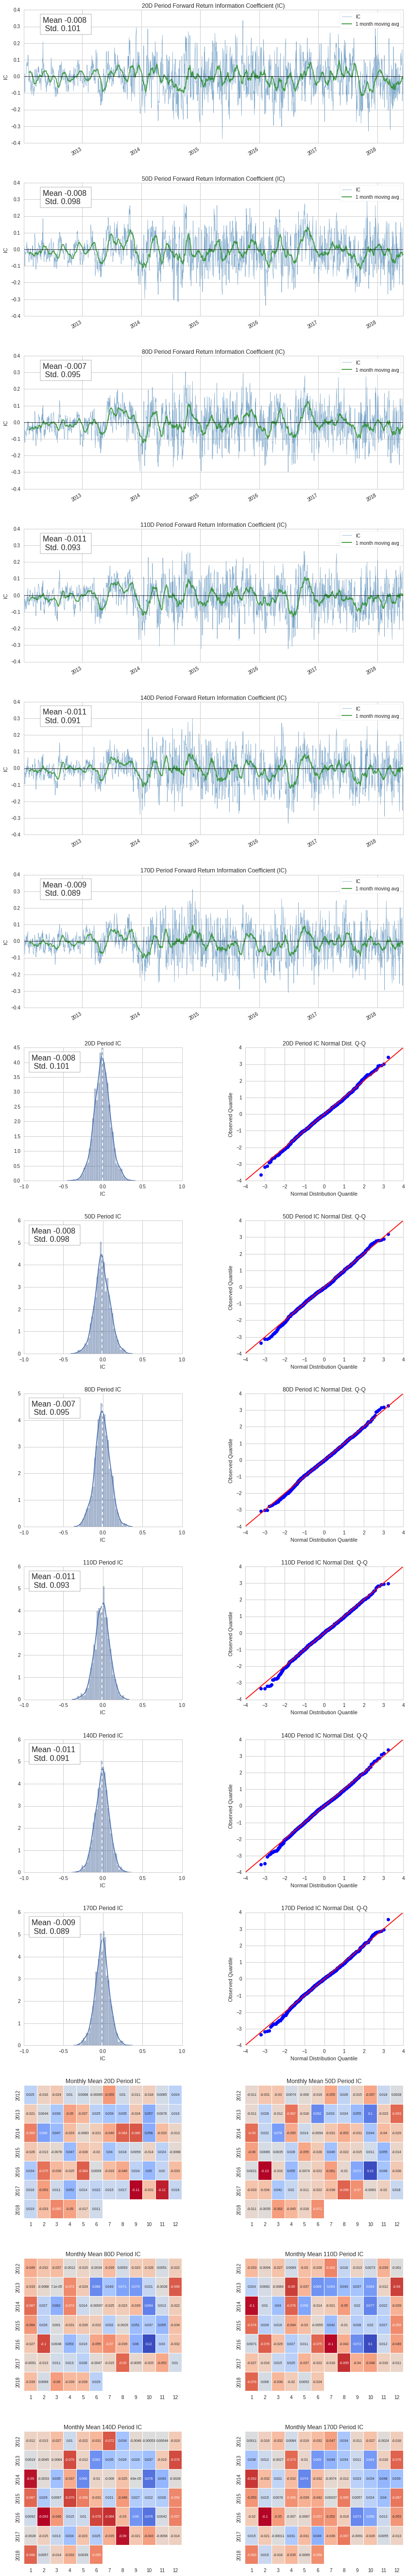

Turnover Analysis


110D   140D   170D    20D    50D    80D
Quantile 1 Mean Turnover   0.813  0.821  0.824  0.761  0.788  0.805
Quantile 2 Mean Turnover   0.498  0.509  0.518  0.423  0.462  0.482

20D    50D    80D   110D   140D  170D
Mean Factor Rank Autocorrelation  0.057  0.033  0.024  0.014  0.016  0.01

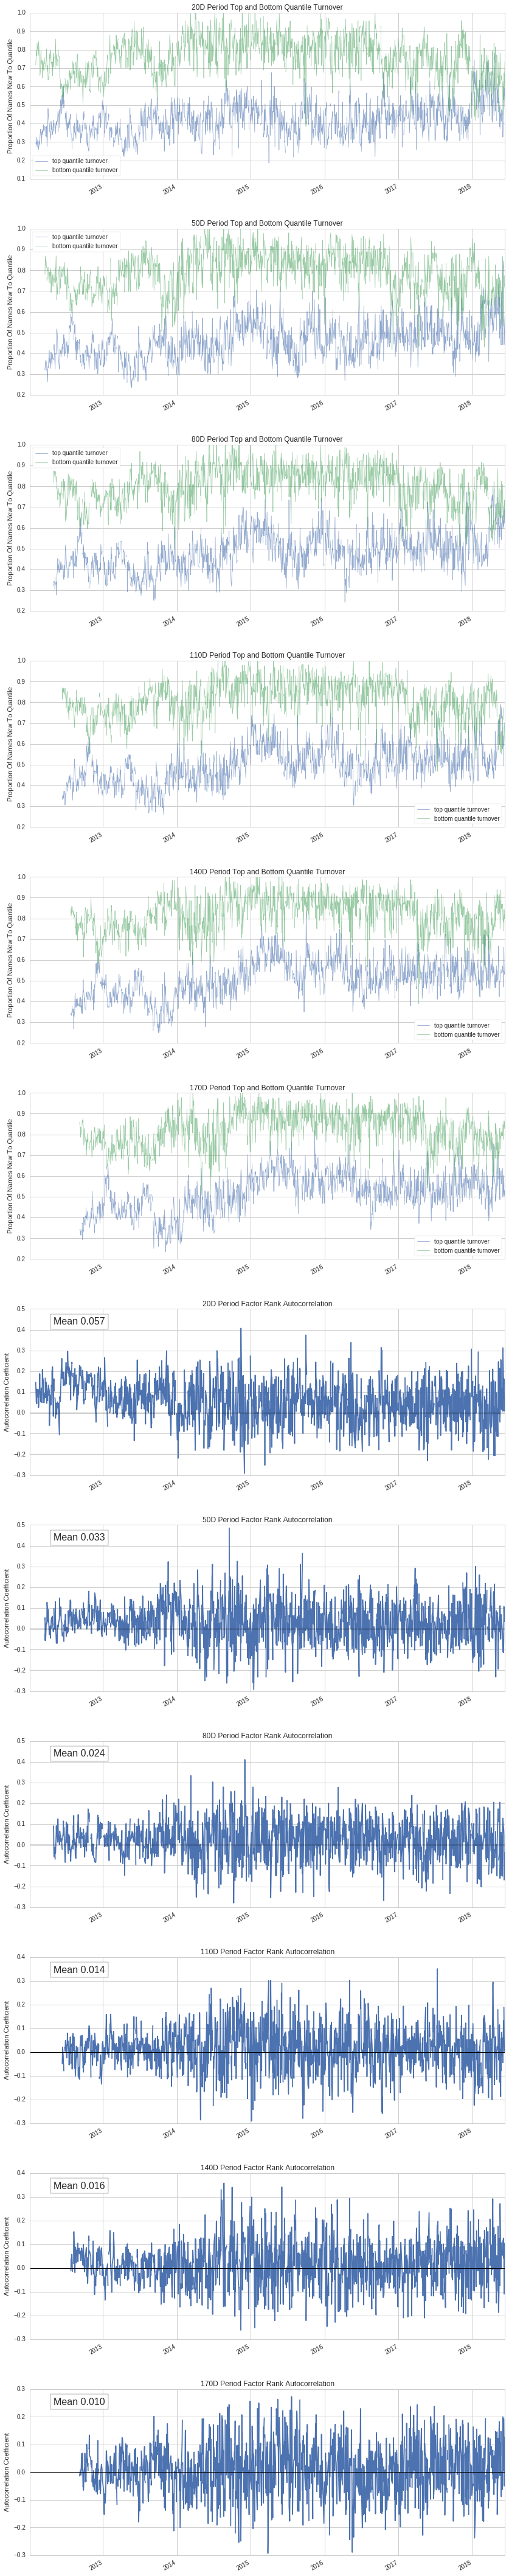

In [27]:
from alphalens.tears import create_full_tear_sheet
create_full_tear_sheet(factor_data=factor_data)

### Disclaimer

Thanks to Saba Nejad, Jamie McCorriston and Thomas Wiecki for their contribution to this notebook.